## A crop classifier
The dataset is a 1000 images containining maize, rice, wheat, sugarcane and jute. Each class has 200 images varying between aerial and ground images. 

In [5]:
import numpy as np    
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Crops/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

Sample Jute


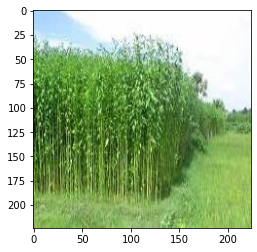

Sample Rice


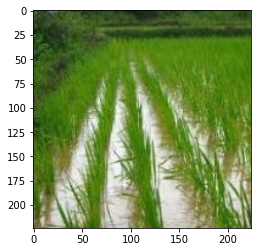

Sample Wheat


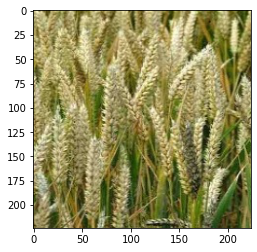

Sample Maize


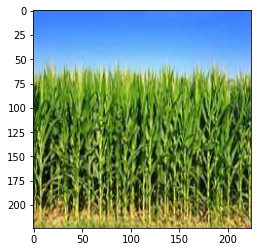

Sample Sugarcane


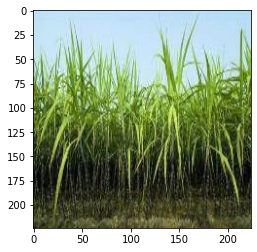

In [43]:
from tensorflow.keras.utils import img_to_array, load_img

#Show dataset example

print("Sample Jute")
plt.imshow(load_img("/content/drive/MyDrive/Crops/input/training_images/jute/jute001ahf.jpeg"))
plt.show()

print("Sample Rice")
plt.imshow(load_img("/content/drive/MyDrive/Crops/input/training_images/rice/rice001ahs.jpeg"))
plt.show()

print("Sample Wheat")
plt.imshow(load_img("/content/drive/MyDrive/Crops/input/training_images/wheat/wheat003.jpeg"))
plt.show()

print("Sample Maize")
plt.imshow(load_img("/content/drive/MyDrive/Crops/input/training_images/maize/maize002a.jpeg"))
plt.show()

print("Sample Sugarcane")
plt.imshow(load_img("/content/drive/MyDrive/Crops/input/training_images/sugarcane/sugarcane0004a.jpeg"))
plt.show()



In [8]:
df = pd.read_csv("/content/drive/MyDrive/Crops/input/Crop_details.csv")
df.head()  # returns the first n rows

,Unnamed: 0,path,crop,croplabel
0,0,/kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg,sugarcane,3
1,1,/kaggle/input/kag2/sugarcane/sugarcane034a.jpeg,sugarcane,3
2,2,/kaggle/input/kag2/sugarcane/sugarcane032arot....,sugarcane,3
3,3,/kaggle/input/kag2/sugarcane/sugarcane036ahs.jpeg,sugarcane,3
4,4,/kaggle/input/kag2/sugarcane/sugarcane023ahs.jpeg,sugarcane,3


In [9]:
categories = os.listdir("/content/drive/MyDrive/Crops/input/training_images")
categories

['wheat', 'sugarcane', 'rice', 'maize', 'jute']

In [10]:
# Set up the training generator

def train_val_generator(training_dir, validation_dir):
  '''
  Creates the training datagenerator

  Args: training_dir (string) : directory of the training images

  Returns: train_generator : tuple containing the generator
  '''

  # Instantiating ImageDataGenerator for training
  train_datagen = ImageDataGenerator(rescale= 1.0/255.0,
                                     horizontal_flip = True,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2,
                                     fill_mode = 'nearest',
                                     rotation_range = 30,
                                     zoom_range = 0.2,
                                     shear_range = 0.2
                                     )
  
  train_generator = train_datagen.flow_from_directory(directory = training_dir,
                                                      batch_size = 32,
                                                      class_mode = 'categorical',
                                                      target_size = (224,224))
  
  validation_datagen = ImageDataGenerator(rescale=1.0/255)

  validation_generator = validation_datagen.flow_from_directory(directory = validation_dir,
                                                                batch_size = 32,
                                                                class_mode = 'categorical',
                                                                target_size = (224, 224))
  
  return train_generator, validation_generator

In [11]:
#Display training and validation generators
train_generator, validation_generator = train_val_generator("/content/drive/MyDrive/Crops/input/training_images", "/content/drive/MyDrive/Crops/input/validation_images")

Found 804 images belonging to 5 classes.
Found 221 images belonging to 5 classes.


In [12]:
#Load VGG26 model with imagenet weights

vgg = VGG16(input_shape = (224,224,3),
                  include_top = False,
                  weights = "imagenet",
                  pooling = 'avg')

for layers in vgg.layers:
  layers.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Add new top layers to vgg model
model = tf.keras.models.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Dense(512, activation ='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(5, activation = 'sigmoid')) # output layer

In [15]:
# Compile the model

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"])

In [16]:
# Inspect parameters
total_parameters = model.count_params()
number_of_trainable_parameters = sum(w.shape.num_elements() for w in model.trainable_weights)

print(f"There are {total_parameters:,} total parmeters in the model of which {number_of_trainable_parameters:,} are trainable")

There are 15,109,957 total parmeters in the model of which 395,269 are trainable


In [19]:
# Train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    )

Epoch 1/50
26/26 [==============================] - 263s 11s/step - loss: 1.4722 - accuracy: 0.3595 - val_loss: 1.3336 - val_accuracy: 0.5023
Epoch 2/50
26/26 [==============================] - 13s 514ms/step - loss: 1.3011 - accuracy: 0.4565 - val_loss: 1.1969 - val_accuracy: 0.4751
Epoch 3/50
26/26 [==============================] - 13s 509ms/step - loss: 1.2251 - accuracy: 0.4863 - val_loss: 1.0821 - val_accuracy: 0.5566
Epoch 4/50
26/26 [==============================] - 13s 509ms/step - loss: 1.1012 - accuracy: 0.5522 - val_loss: 1.0715 - val_accuracy: 0.5747
Epoch 5/50
26/26 [==============================] - 13s 509ms/step - loss: 1.0195 - accuracy: 0.6095 - val_loss: 0.8675 - val_accuracy: 0.6878
Epoch 6/50
26/26 [==============================] - 13s 509ms/step - loss: 0.8856 - accuracy: 0.6580 - val_loss: 0.8049 - val_accuracy: 0.7014
Epoch 7/50
26/26 [==============================] - 13s 510ms/step - loss: 0.9045 - accuracy: 0.6505 - val_loss: 0.8646 - val_accuracy: 0.6335


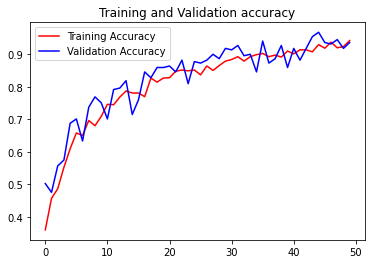

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot training and val curves

acc = history.history['accuracy']
val_acc = history.history ['val_accuracy']
loss = history.history ['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc = 0)
plt.figure()

plt.show()